In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

# 1A: Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are nu- meric.

In [2]:
df_train = pd.read_csv("../data/aps_failure_training_set.csv",skiprows=20)
df_test = pd.read_csv("../data/aps_failure_test_set.csv",skiprows=20)

In [3]:
df_train

class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg   76698     na  2130706438    280      0      0      0      0   
1       neg   33058     na           0     na      0      0      0      0   
2       neg   41040     na         228    100      0      0      0      0   
3       neg      12      0          70     66      0     10      0      0   
4       neg   60874     na        1368    458      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995   neg  153002     na         664    186      0      0      0      0   
59996   neg    2286     na  2130706538    224      0      0      0      0   
59997   neg     112      0  2130706432     18      0      0      0      0   
59998   neg   80292     na  2130706432    494      0      0      0      0   
59999   neg   40222     na         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  ee_007  ee_008  \
0          0  ...  1240520  493384   721044   469792   339156  157956   73224   
1          0  ...   421400  178064   293306   245416   133654   81140   97576   
2          0  ...   277378  159812   423992   409564   320746  158022   95128   
3          0  ...      240      46       58       44       10       0       0   
4          0  ...   622012  229790   405298   347188   286954  311560  433954   
...      ...  ...      ...     ...      ...      ...      ...     ...     ...   
59995      0  ...   998500  566884  1290398  1218244  1019768  717762  898642   
59996      0  ...    10578    6760    21126    68424      136       0       0   
59997      0  ...      792     386      452      144      146    2622       0   
59998      0  ...   699352  222654   347378   225724   194440  165070  802280   
59999      0  ...   440066  183200   344546   254068   225148  158304  170384   

       ee_009 ef_000 eg_000  
0           0      0      0  
1        1500      0      0  
2         514      0      0  
3           0      4     32  
4        1218      0      0  
...       ...    ...    ...  
59995   28588      0      0  
59996       0      0      0  
59997       0      0      0  
59998  388422      0      0  
59999     158      0      0  

[60000 rows x 171 columns]

In [4]:
df_test

class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg      60      0          20     12      0      0      0      0   
1       neg      82      0          68     40      0      0      0      0   
2       neg   66002      2         212    112      0      0      0      0   
3       neg   59816     na        1010    936      0      0      0      0   
4       neg    1814     na         156    140      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
15995   neg   81852     na  2130706432    892      0      0      0      0   
15996   neg      18      0          52     46      8     26      0      0   
15997   neg   79636     na        1670   1518      0      0      0      0   
15998   neg     110     na          36     32      0      0      0      0   
15999   neg       8      0           6      4      2      2      0      0   

      ag_002  ...  ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008  \
0          0  ...    1098     138     412     654       78      88       0   
1          0  ...    1068     276    1620     116       86     462       0   
2          0  ...  495076  380368  440134  269556  1315022  153680     516   
3          0  ...  540820  243270  483302  485332   431376  210074  281662   
4          0  ...    7646    4144   18466   49782     3176     482      76   
...      ...  ...     ...     ...     ...     ...      ...     ...     ...   
15995      0  ...  632658  273242  510354  373918   349840  317840  960024   
15996      0  ...     266      44      46      14        2       0       0   
15997      0  ...  806832  449962  778826  581558   375498  222866  358934   
15998      0  ...     588     210     180     544     1004    1338      74   
15999      0  ...      46      10      48      14       42      46       0   

      ee_009 ef_000 eg_000  
0          0      0      0  
1          0      0      0  
2          0      0      0  
3       3232      0      0  
4          0      0      0  
...      ...    ...    ...  
15995  25566      0      0  
15996      0      0      0  
15997  19548      0      0  
15998      0      0      0  
15999      0      0      0  

[16000 rows x 171 columns]

In [5]:
df_train = df_train.replace('na', np.nan)
df_test = df_test.replace('na', np.nan)
df_train = df_train.replace('neg', 0)
df_test = df_test.replace('neg', 0)
df_train = df_train.replace('pos', 1)
df_test = df_test.replace('pos', 1)

# 1B(i): Research what types of techniques are usually used for dealing with data with missing values.2 Pick at least one of them and apply it to this data in the next steps.

Some techniques I researched were KNN Imputer, Imputation with mean, median, or mode or imputation from regression. I decided to use imputation with median because I felt it may be more rigid to outliers. KNN Imputer is too computationally intensive for this large of a dataset

In [6]:
imputation = SimpleImputer(missing_values=np.nan, strategy='median')
imputation.fit(df_train)
imputed_train_df = pd.DataFrame(imputation.transform(df_train),columns=df_train.columns)

imputed_test_df = pd.DataFrame(imputation.transform(df_test),columns=df_test.columns)

In [7]:
imputed_combined_df = pd.concat([imputed_train_df,imputed_test_df])
imputed_combined_features_df = imputed_combined_df.drop("class",axis=1)
imputed_combined_features_df

aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0      76698.0     0.0  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1      33058.0     0.0  0.000000e+00   126.0     0.0     0.0     0.0     0.0   
2      41040.0     0.0  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3         12.0     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4      60874.0     0.0  1.368000e+03   458.0     0.0     0.0     0.0     0.0   
...        ...     ...           ...     ...     ...     ...     ...     ...   
15995  81852.0     0.0  2.130706e+09   892.0     0.0     0.0     0.0     0.0   
15996     18.0     0.0  5.200000e+01    46.0     8.0    26.0     0.0     0.0   
15997  79636.0     0.0  1.670000e+03  1518.0     0.0     0.0     0.0     0.0   
15998    110.0     0.0  3.600000e+01    32.0     0.0     0.0     0.0     0.0   
15999      8.0     0.0  6.000000e+00     4.0     2.0     2.0     0.0     0.0   

       ag_002  ag_003  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0         0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1         0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2         0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3         0.0   318.0  ...      240.0      46.0      58.0      44.0      10.0   
4         0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0   
...       ...     ...  ...        ...       ...       ...       ...       ...   
15995     0.0     0.0  ...   632658.0  273242.0  510354.0  373918.0  349840.0   
15996     0.0     0.0  ...      266.0      44.0      46.0      14.0       2.0   
15997     0.0     0.0  ...   806832.0  449962.0  778826.0  581558.0  375498.0   
15998     0.0     0.0  ...      588.0     210.0     180.0     544.0    1004.0   
15999     0.0     0.0  ...       46.0      10.0      48.0      14.0      42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  
0      157956.0   73224.0      0.0     0.0     0.0  
1       81140.0   97576.0   1500.0     0.0     0.0  
2      158022.0   95128.0    514.0     0.0     0.0  
3           0.0       0.0      0.0     4.0    32.0  
4      311560.0  433954.0   1218.0     0.0     0.0  
...         ...       ...      ...     ...     ...  
15995  317840.0  960024.0  25566.0     0.0     0.0  
15996       0.0       0.0      0.0     0.0     0.0  
15997  222866.0  358934.0  19548.0     0.0     0.0  
15998    1338.0      74.0      0.0     0.0     0.0  
15999      46.0       0.0      0.0     0.0     0.0  

[76000 rows x 170 columns]

# 1B(ii) For each of the 170 features, calculate the coefficient of variation CV = ms , where s is sample standard deviation and m is sample mean.

In [8]:
coefficient_cv_dict = {}
for feature in imputed_combined_features_df.columns:
    s = imputed_combined_features_df[[feature]].std().item() 
    m = imputed_combined_features_df[[feature]].mean().item()
    coefficient_cv = s / m
    coefficient_cv_dict[feature]=coefficient_cv
cv_df = pd.DataFrame(coefficient_cv_dict.items(), columns=['Feature', 'Coefficient_CV'])
cv_df.index = cv_df.index +1
pd.set_option('display.max_rows', None)
display(cv_df)

Feature  Coefficient_CV
1    aa_000        4.328608
2    ab_000        9.740521
3    ac_000        2.309299
4    ad_000      274.791581
5    ae_000       23.271357
6    af_000       19.007953
7    ag_000       92.507510
8    ag_001       42.566145
9    ag_002       17.827963
10   ag_003        8.854130
11   ag_004        5.538278
12   ag_005        2.994140
13   ag_006        2.364871
14   ag_007        2.838124
15   ag_008        6.343974
16   ag_009       32.535395
17   ah_000        2.327389
18   ai_000       18.701476
19   aj_000       43.598946
20   ak_000       84.875146
21   al_000        9.210860
22     am_0        9.163255
23   an_000        2.265641
24   ao_000        2.286947
25   ap_000        3.108149
26   aq_000        2.871171
27   ar_000       11.079624
28   as_000      115.082077
29   at_000       23.431463
30   au_000       86.992248
31   av_000        5.957936
32   ax_000        4.001075
33   ay_000       41.372451
34   ay_001       49.814404
35   ay_002       38.782855
36   ay_003       28.655626
37   ay_004       33.419792
38   ay_005       12.147466
39   ay_006        3.052519
40   ay_007        3.279839
41   ay_008        3.986253
42   ay_009       78.350868
43   az_000        9.096061
44   az_001        7.448114
45   az_002       12.171542
46   az_003        7.649580
47   az_004        2.870388
48   az_005        3.094270
49   az_006        8.804743
50   az_007       15.559201
51   az_008       22.672582
52   az_009       78.895508
53   ba_000        2.705436
54   ba_001        2.663834
55   ba_002        2.906241
56   ba_003        2.746986
57   ba_004        2.657686
58   ba_005        2.721681
59   ba_006        3.021210
60   ba_007        2.856351
61   ba_008        6.784522
62   ba_009        9.638320
63   bb_000        2.423157
64   bc_000        7.013292
65   bd_000        5.316389
66   be_000        6.599003
67   bf_000        7.355762
68   bg_000        2.325169
69   bh_000        2.641144
70   bi_000        3.030443
71   bj_000        3.605385
72   bk_000        0.818072
73   bl_000        0.869358
74   bm_000        0.848940
75   bn_000        0.834847
76   bo_000        0.790371
77   bp_000        0.751582
78   bq_000        0.716587
79   br_000        0.687110
80   bs_000        1.051316
81   bt_000        4.327020
82   bu_000        2.422843
83   bv_000        2.422843
84   bx_000        2.553485
85   by_000        2.450963
86   bz_000        6.347286
87   ca_000        0.929880
88   cb_000        0.907198
89   cc_000        2.569486
90   cd_000        0.000000
91   ce_000        2.271142
92   cf_000      275.595820
93   cg_000        4.015927
94   ch_000       76.454109
95   ci_000        2.400682
96   cj_000       11.256765
97   ck_000        3.055174
98   cl_000       14.454323
99   cm_000        5.611749
100  cn_000       28.303427
101  cn_001       12.773060
102  cn_002        6.843616
103  cn_003        4.276690
104  cn_004        2.660016
105  cn_005        2.351456
106  cn_006        3.076022
107  cn_007        6.166486
108  cn_008        9.891234
109  cn_009       31.323538
110  co_000      275.068138
111  cp_000       13.525446
112  cq_000        2.422843
113  cr_000       54.789865
114  cs_000        1.982389
115  cs_001        3.494968
116  cs_002        5.180335
117  cs_003        3.201688
118  cs_004        4.792500
119  cs_005        2.516849
120  cs_006        2.113509
121  cs_007        4.965287
122  cs_008       57.733094
123  cs_009      194.720937
124  ct_000        7.383279
125  cu_000        6.484028
126  cv_000        1.821306
127  cx_000        4.715580
128  cy_000       36.403918
129  cz_000       13.955640
130  da_000       32.765255
131  db_000        5.703489
132  dc_000        1.707415
133  dd_000        3.114233
134  de_000        4.353610
135  df_000      119.384411
136  dg_000       37.172988
137  dh_000      120.759504
138  di_000       12.054533
139  dj_000      130.915233
140  dk_000       39.146334
141  dl_000       40.153018
142  dm_000       37.039731


# 1B(iii) Plot a correlation matrix for your features using pandas or any other tool.

Text(0.5, 1.0, 'Correlation Matrix of Dataset Features')

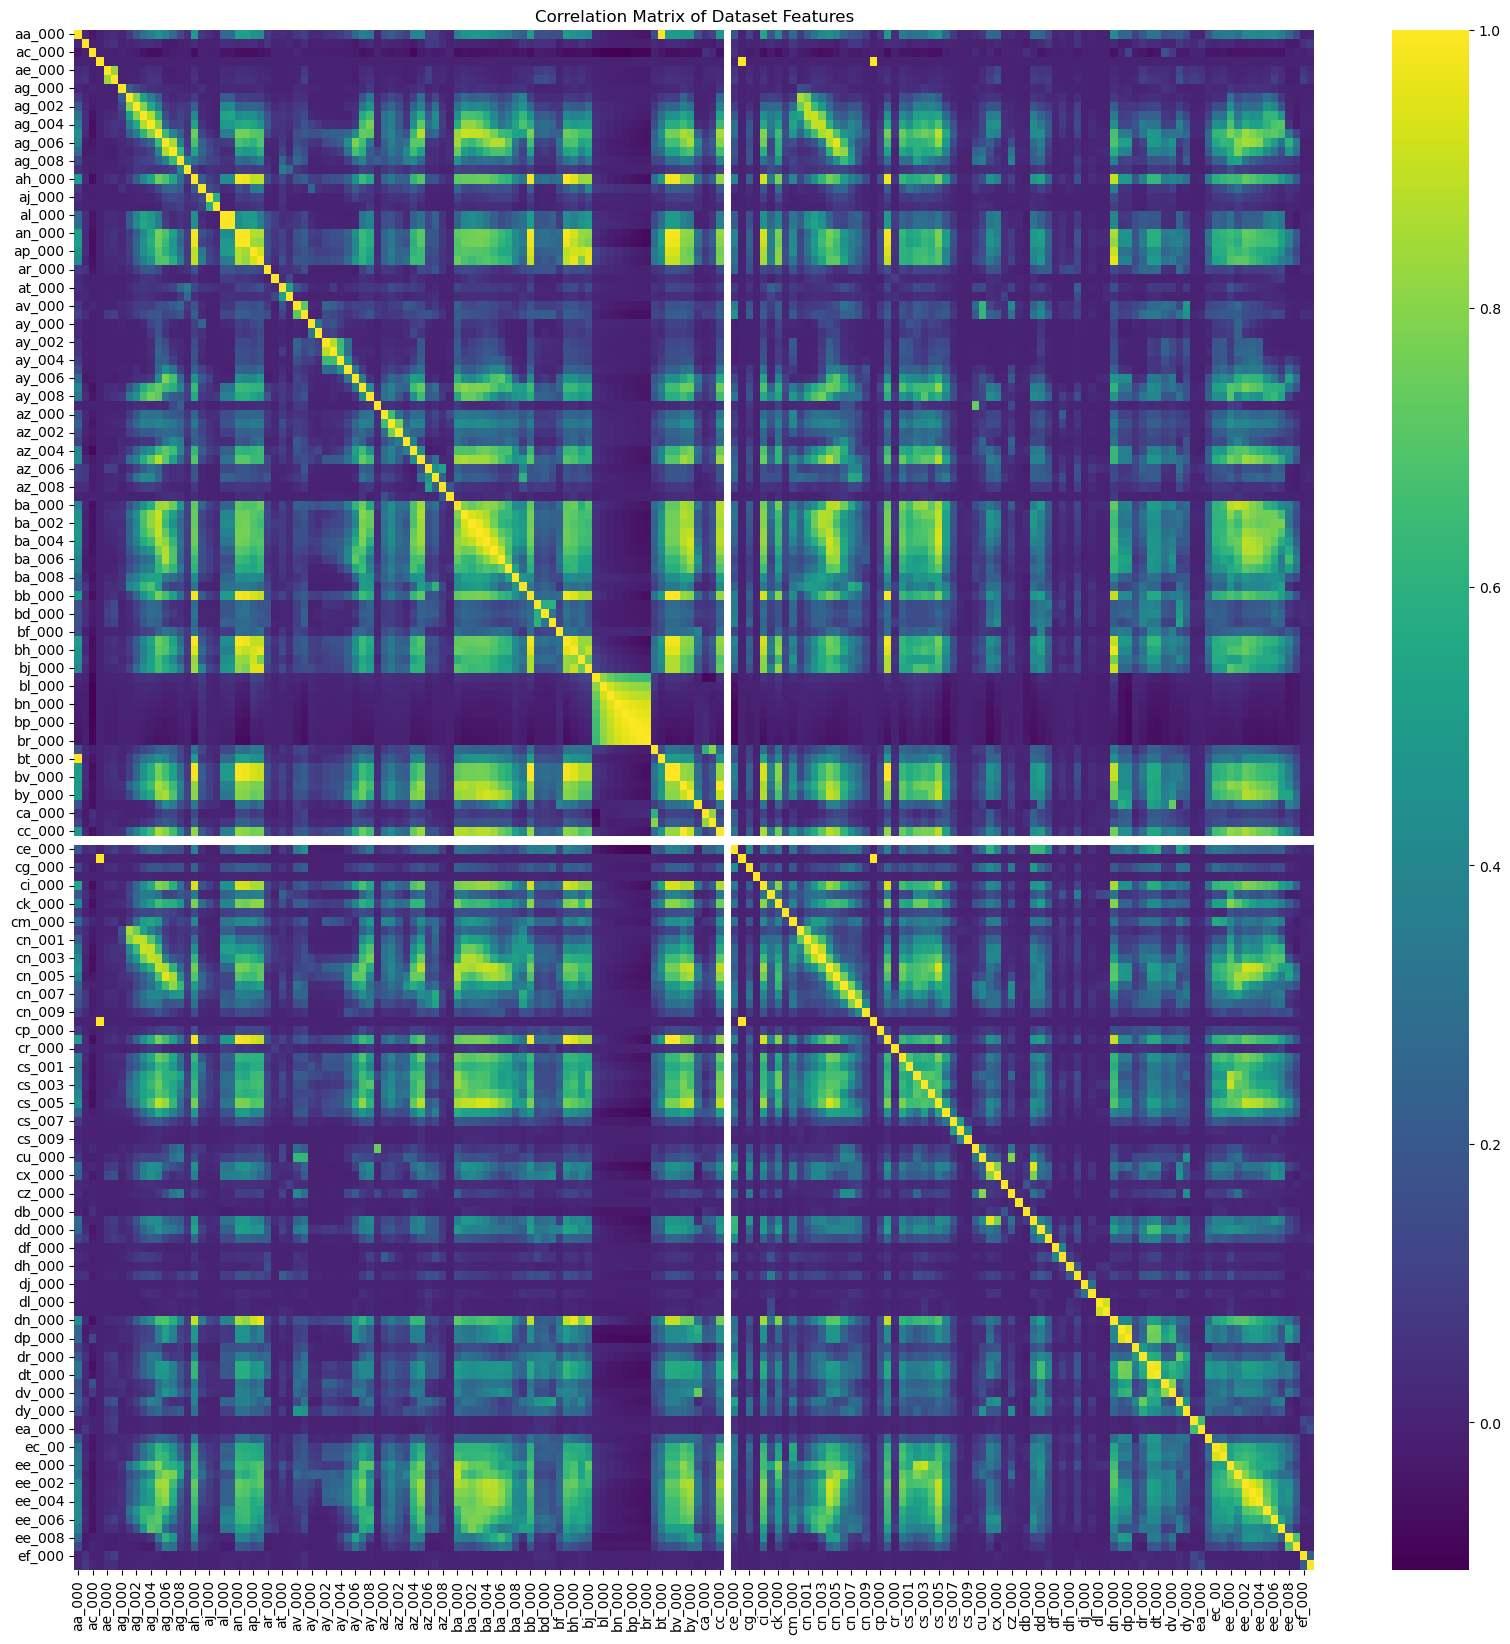

In [9]:
corr_matrix = imputed_combined_features_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='viridis')
plt.title('Correlation Matrix of Dataset Features')

From the correlation matrix above, there is a clear strong positive correlation between variables 


br_000 and bp_000


br_000 and bn_000


bp_000 and bn_000 

# 1B(iv): Pick SQRT⌊170⌋ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

floor[sqrt(170)] = 13 features

### The 13 features with the highest CV

In [10]:
top_13_features_df = cv_df.sort_values(by='Coefficient_CV', ascending=False).head(13)
print(top_13_features_df)

    Feature  Coefficient_CV
92   cf_000      275.595820
110  co_000      275.068138
4    ad_000      274.791581
123  cs_009      194.720937
139  dj_000      130.915233
137  dh_000      120.759504
135  df_000      119.384411
28   as_000      115.082077
7    ag_000       92.507510
30   au_000       86.992248
20   ak_000       84.875146
52   az_009       78.895508
42   ay_009       78.350868


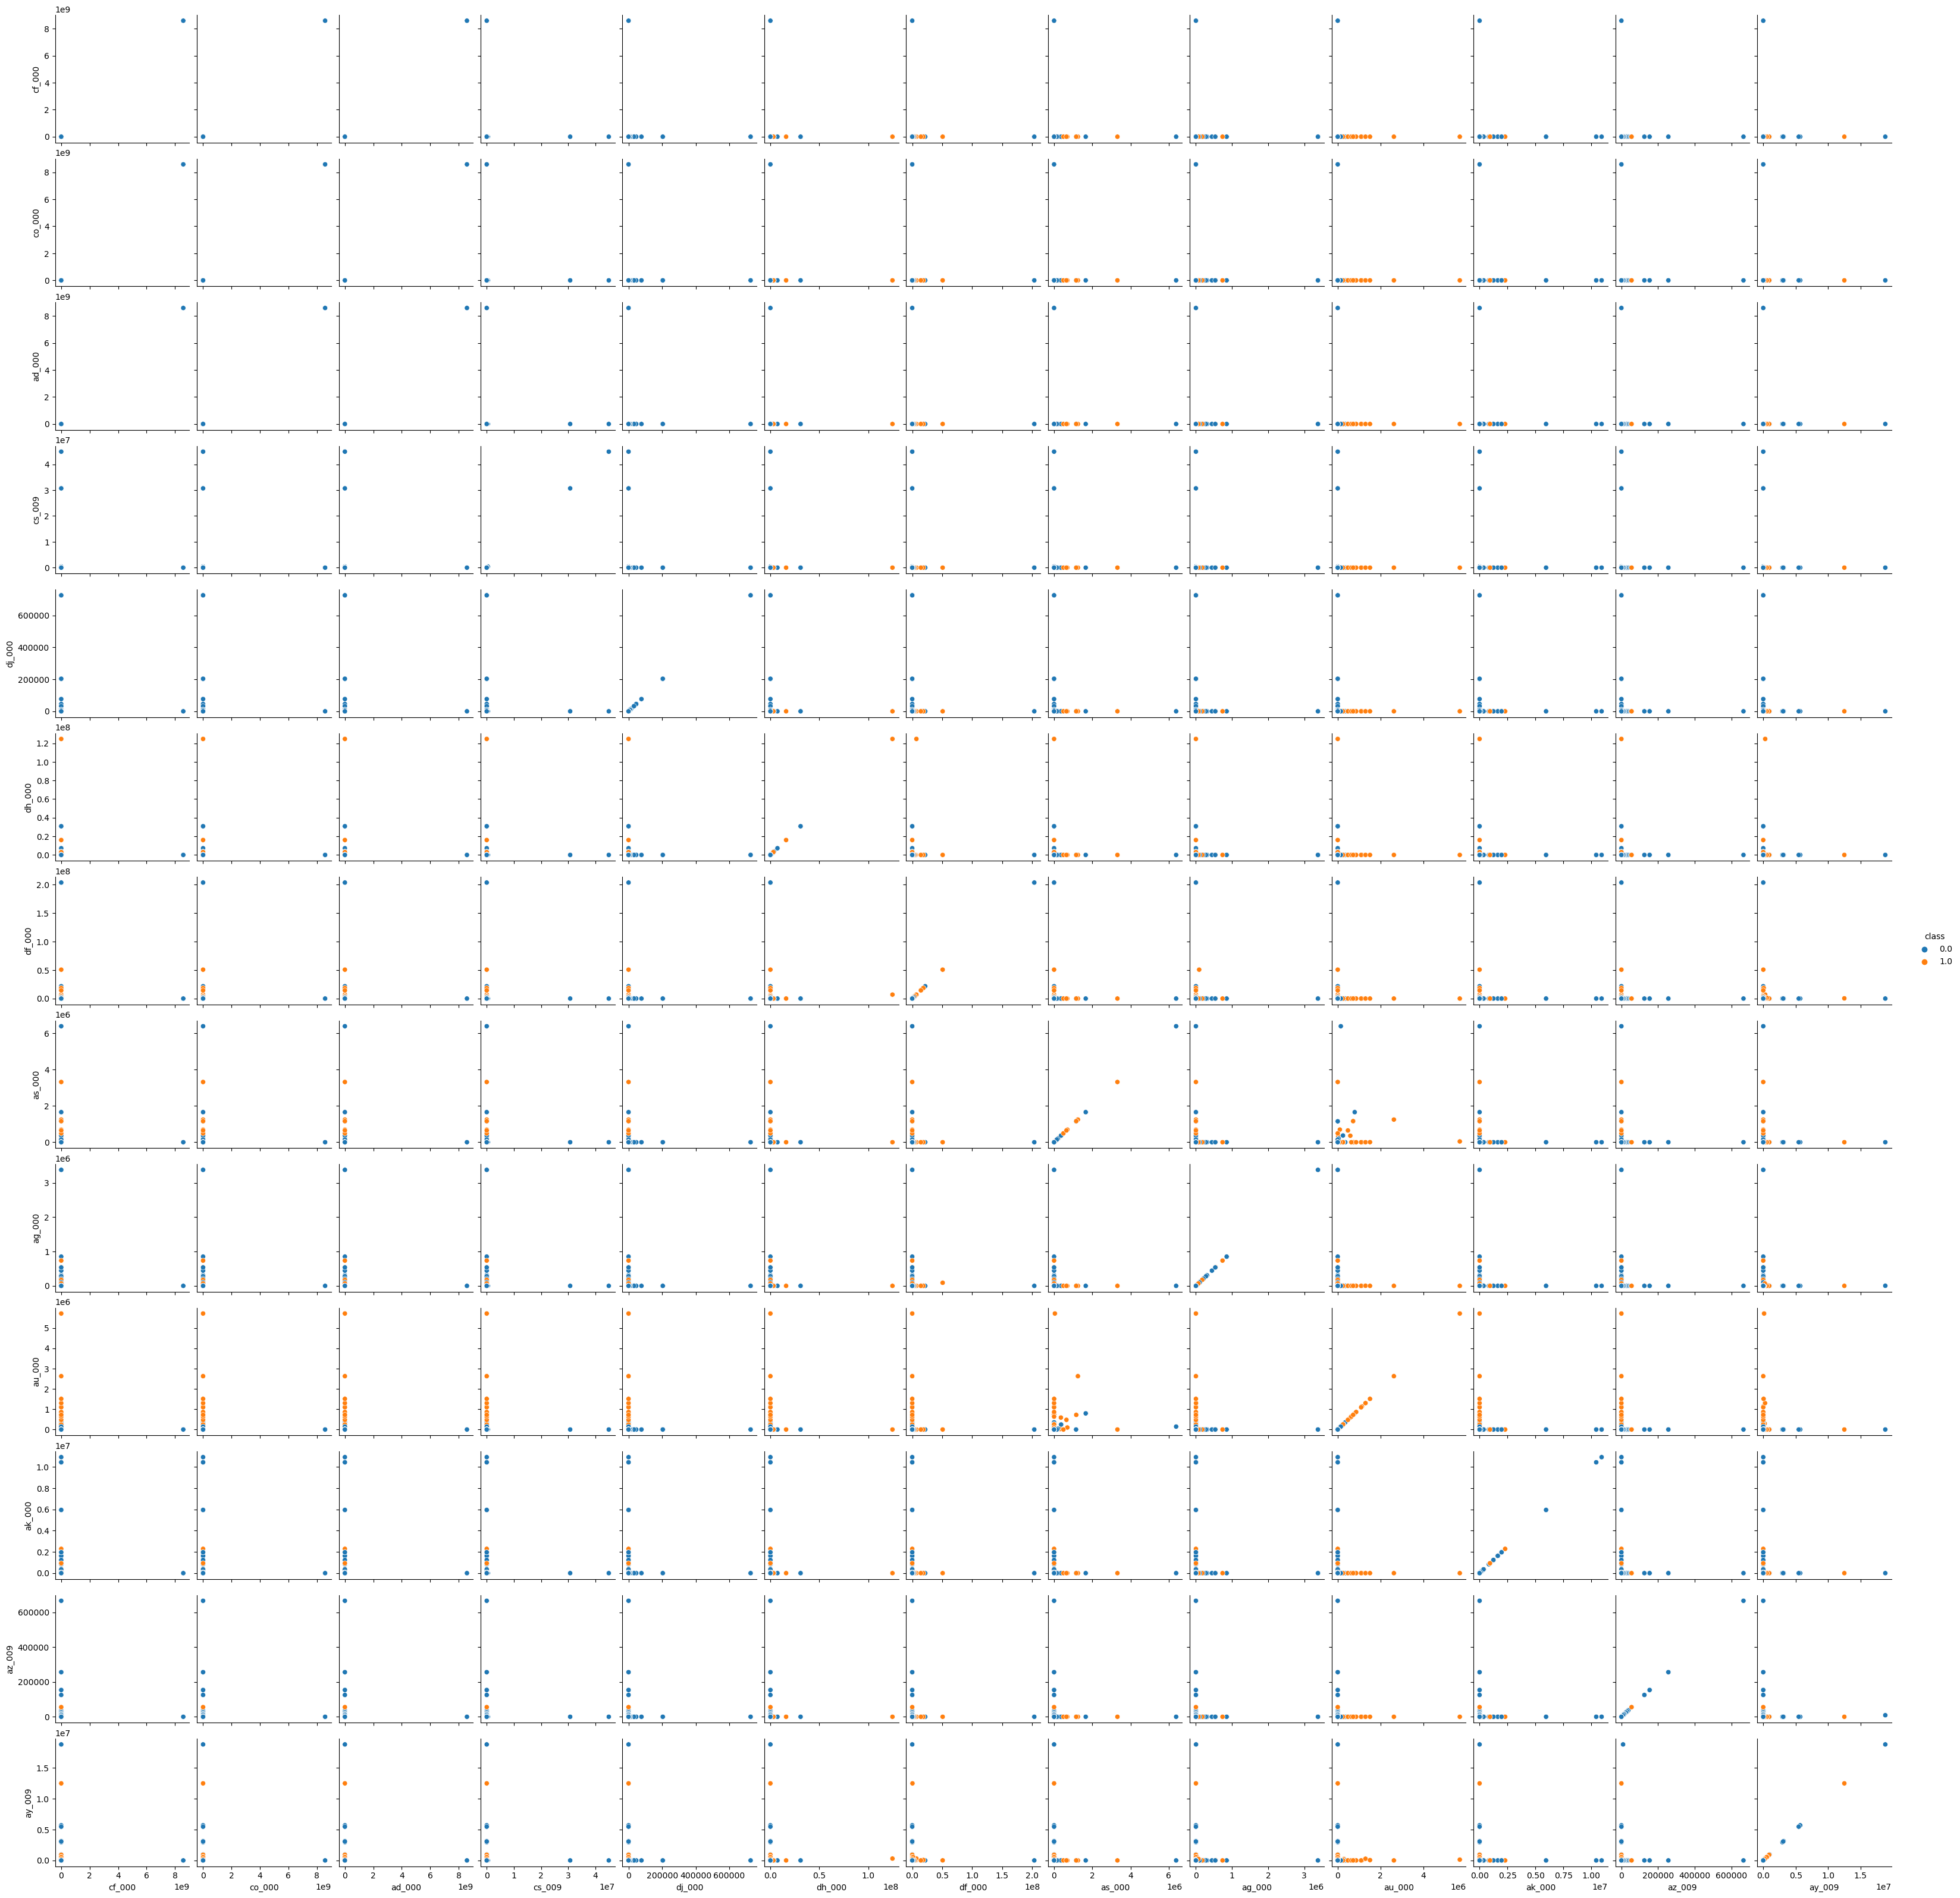

In [11]:
top13_features = imputed_combined_df[["class","cf_000","co_000","ad_000","cs_009","dj_000","dh_000","df_000","as_000","ag_000","au_000","ak_000","az_009","ay_009"]]
sns.pairplot(top13_features,hue="class",diag_kind=None)

It is hard to draw any significant conclusions about these variables as there can are no clear correlations seen. In addition, both the negative and positive instances seem to overlap each other in many of the scatter plots.

[None]

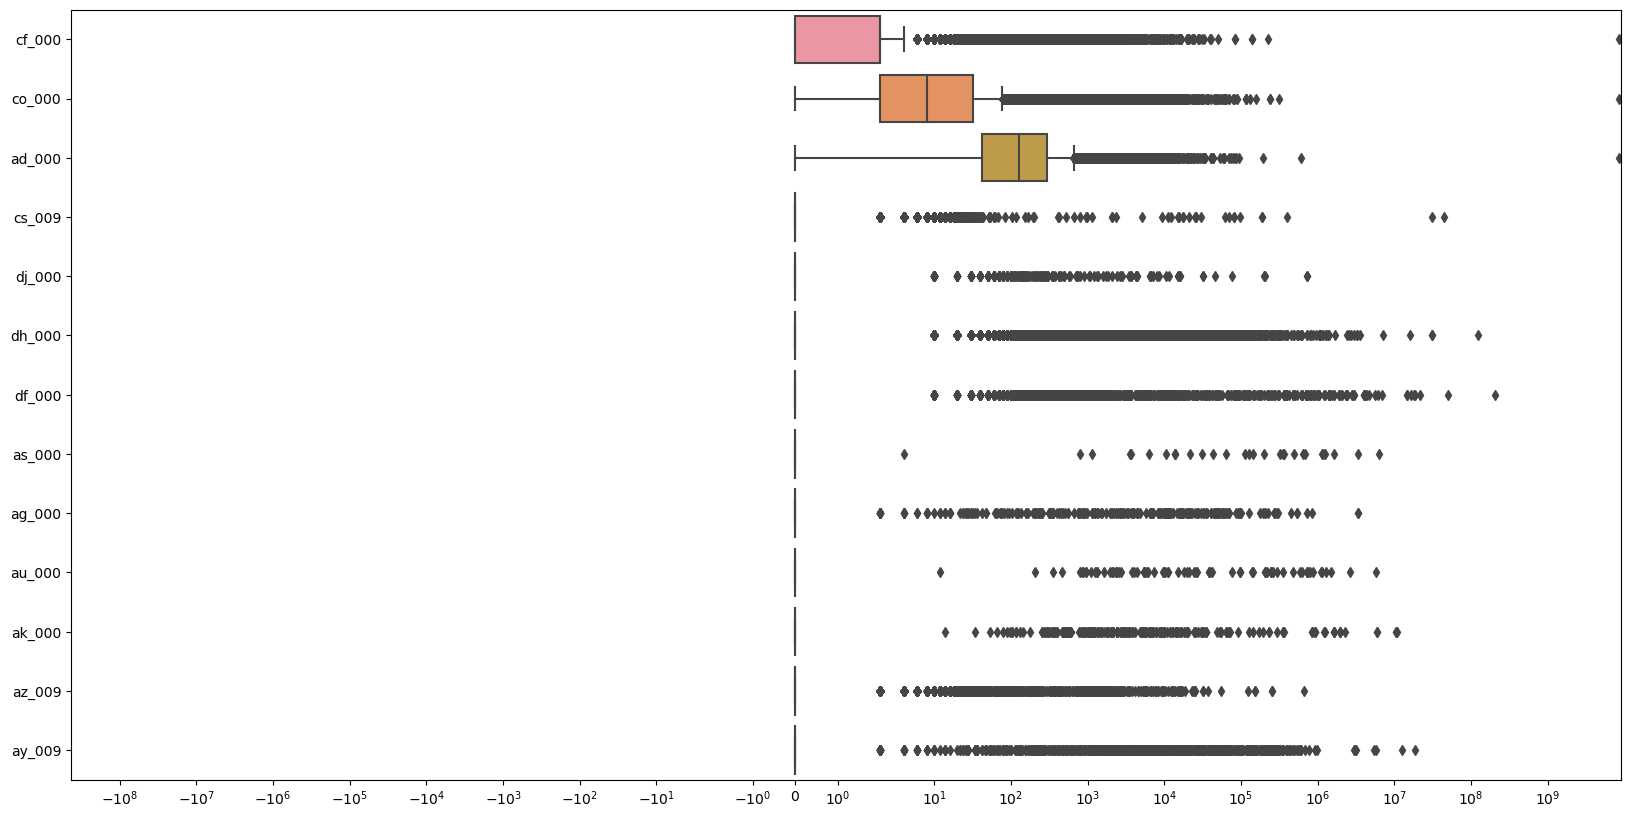

In [12]:
plt.figure(figsize=(20, 10))
boxplot = sns.boxplot(data=imputed_combined_df[["cf_000","co_000","ad_000","cs_009","dj_000","dh_000","df_000","as_000","ag_000","au_000","ak_000","az_009","ay_009"]], orient="h")
boxplot.set(xscale = "symlog")

From the boxplot above, only the features cf_000 , co_000 and ad_000 have clear visualized distributions. After analyzing the dataset, the remaining features tend to have a large amount of datapoints concentrated at 0, thus their distribution exists at 0. The points that are visualized are outliers which have been calculated using the 1.5*IQR Method.

# 1B(v): Determine the number of positive and negative data. Is this data set imbalanced?

In [13]:
class_value_train = imputed_train_df["class"].value_counts()
class_value_test = imputed_test_df["class"].value_counts()
class_value = imputed_combined_df["class"].value_counts()


print("Class Value Counts for Train Set",class_value_train)
print("\nClass Value Counts for Test Set",class_value_test)
print("\nClass Value Counts for Combined Train and Test Set",class_value)

Class Value Counts for Train Set class
0.0    59000
1.0     1000
Name: count, dtype: int64

Class Value Counts for Test Set class
0.0    15625
1.0      375
Name: count, dtype: int64

Class Value Counts for Combined Train and Test Set class
0.0    74625
1.0     1375
Name: count, dtype: int64


Yes this dataset is imbalanced. In both the train and the test set the negative class is present in significantly more instances. When looking at the testing set and training set together, around 74,625 of the instances belong to the negative class while 1,375 belong to the positive class.

# 1C: Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [14]:
pd.set_option('display.max_rows', 10)
train_df_x = imputed_train_df.drop("class",axis=1)
train_df_y = imputed_train_df[["class"]]
test_df_x = imputed_test_df.drop("class",axis=1)
test_df_y = imputed_test_df[["class"]]

### Training Set Random Forest

In [15]:
classifier_rf = RandomForestClassifier(oob_score=True, random_state=24, max_depth=8)
classifier_rf.fit(train_df_x, train_df_y)
y_pred_train = classifier_rf.predict(train_df_x)
conf_matrix_train = confusion_matrix(train_df_y, y_pred_train)

The Train Missclassification Rate is 0.00433

Confusion Matrix Random Forest Train:

[[58999     1]
 [  259   741]]


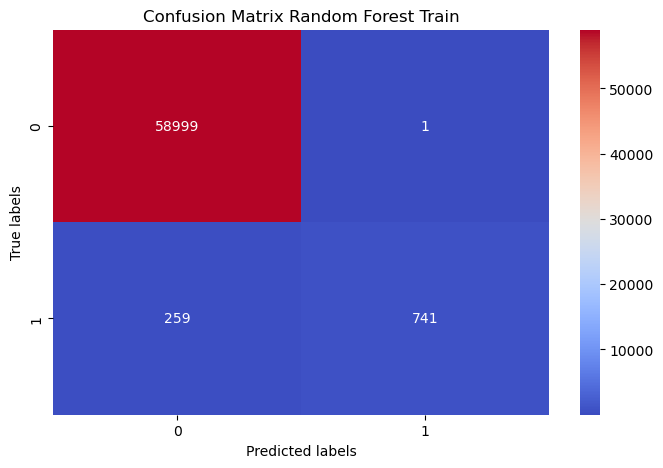

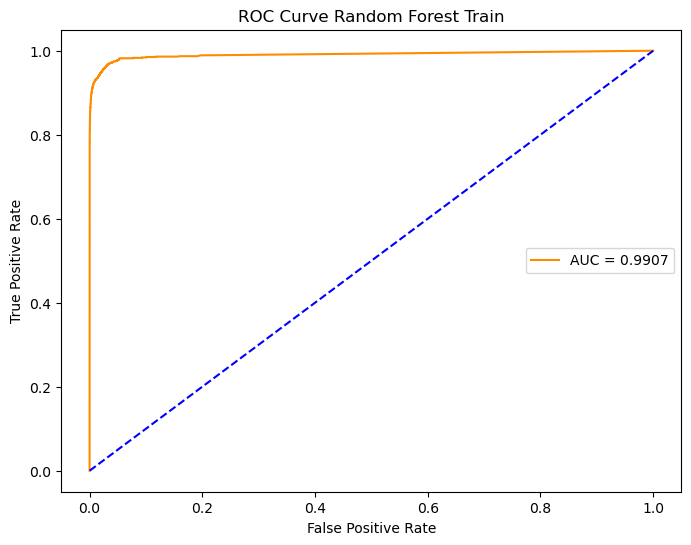

In [16]:
misclassification_train = 1 - accuracy_score(train_df_y, y_pred_train)
print("The Train Missclassification Rate is", round(misclassification_train,5))

print("\nConfusion Matrix Random Forest Train:\n")
print(conf_matrix_train)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Random Forest Train')
plt.show()

y_pred_proba_train = classifier_rf.predict_proba(train_df_x)[:, 1]  
fpr, tpr, thresholds = roc_curve(train_df_y, y_pred_proba_train)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,4)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest Train')
plt.legend(loc="center right")

### Testing Set Random Forest

The Test Missclassification Rate RF is 0.00962

Confusion Matrix Random Forest Test:

[[15611    14]
 [  140   235]]


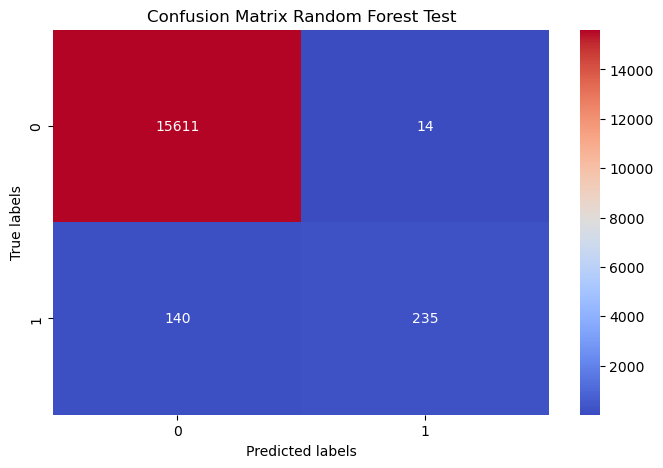

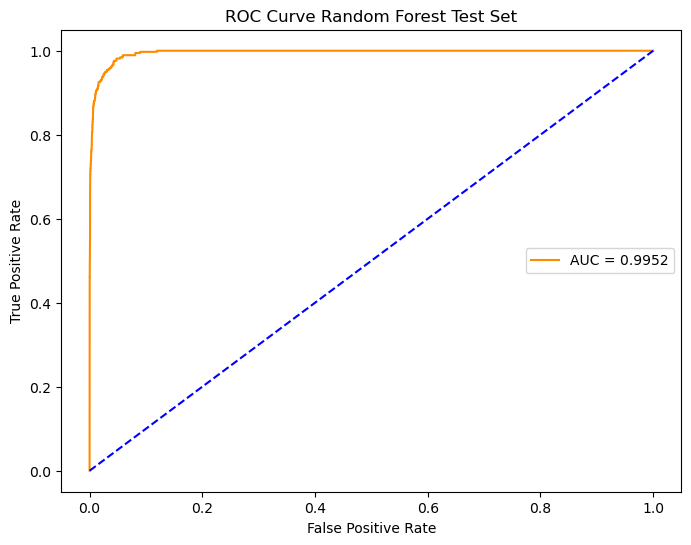

In [17]:
y_pred_test = classifier_rf.predict(test_df_x)

conf_matrix_test = confusion_matrix(test_df_y, y_pred_test)
misclassification_test = 1 - accuracy_score(test_df_y, y_pred_test)
print("The Test Missclassification Rate RF is", round(misclassification_test,5))

print("\nConfusion Matrix Random Forest Test:\n")
print(conf_matrix_test)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Random Forest Test')
plt.show()


y_pred_proba_test = classifier_rf.predict_proba(test_df_x)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df_y, y_pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,4)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest Test Set')
plt.legend(loc="center right")

The Confusion Matrix above shows that the False Negative rate (amount True 1 classes that are predicted 0) is much higher than the False Positive rate showing that the class imbalance has caused overfitting to the negative case.

### Out of Bag Error Estimate

In [18]:
oob_error = 1 - classifier_rf.oob_score_
print("The Out of Bag Error estimate for the Random Forest Classifer above is", round(oob_error,5))
comparison_oob_test = pd.DataFrame([{"Test Error":misclassification_test,"OOB Error":oob_error}])
comparison_oob_test

The Out of Bag Error estimate for the Random Forest Classifer above is 0.00757


Test Error  OOB Error
0    0.009625   0.007567

The Out of Bag Error estimate appears to be a little lower than the test error. This is most likely due to the class imbalance in the dataset as it has been trained heavily on negative cases.

# 1D: Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

I adjusted the max depth parameter to be 8 in order to attempt avoid overfitting. In addition, from research I found that setting class_weight parameter to balanced tells the algorithm to "automatically adjust weights inversely proportional to class frequencies in the input data" such that the less frequent class is given more importance to, in this case the positive class.

https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#

### Training Set Random Forest Accounting for Class Imbalance

The Train Missclassification Rate RF (Accounting for Class Imbalance) is 0.02433

Confusion Matrix Train RF (Accounting for Class Imbalance):

[[57562  1438]
 [   22   978]]


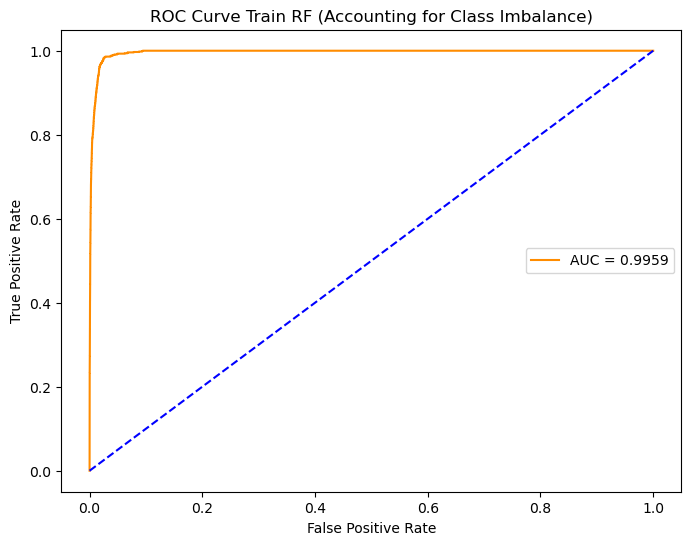

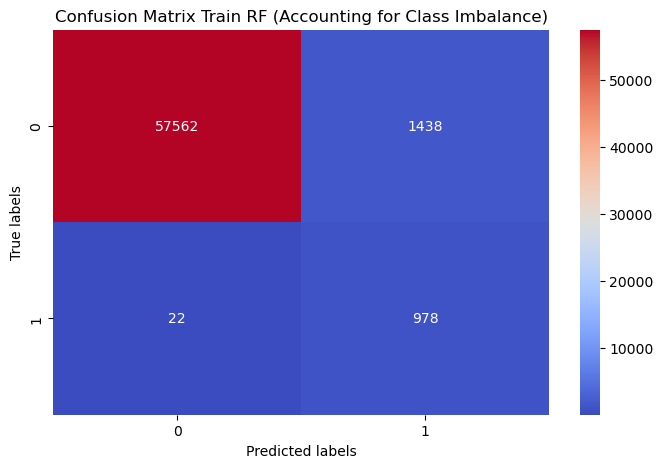

In [19]:
classifier_rf = RandomForestClassifier(oob_score=True, random_state=24, max_depth=8, class_weight='balanced')
classifier_rf.fit(train_df_x, train_df_y)
y_pred_train = classifier_rf.predict(train_df_x)
conf_matrix_train = confusion_matrix(train_df_y, y_pred_train)

misclassification_train = 1 - accuracy_score(train_df_y, y_pred_train)
print("The Train Missclassification Rate RF (Accounting for Class Imbalance) is", round(misclassification_train,5))

y_pred_proba_train = classifier_rf.predict_proba(train_df_x)[:, 1]  
fpr, tpr, thresholds = roc_curve(train_df_y, y_pred_proba_train)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,4)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Train RF (Accounting for Class Imbalance)')
plt.legend(loc="center right")

print("\nConfusion Matrix Train RF (Accounting for Class Imbalance):\n")
print(conf_matrix_train)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train RF (Accounting for Class Imbalance)')
plt.show()

### Testing Set Random Forest Accounting for Class Imbalance

The Test Missclassification Rate RF (Accounting for Class Imbalance) is 0.02481

Confusion Matrix Test RF (Accounting for Class Imbalance):

[[15253   372]
 [   25   350]]


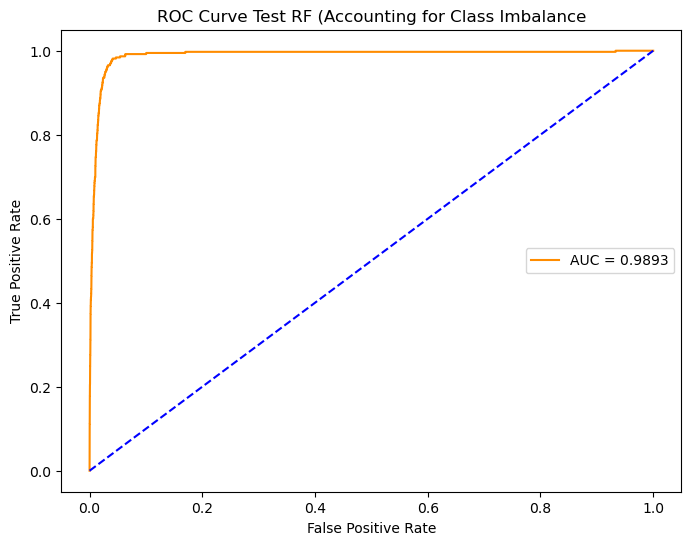

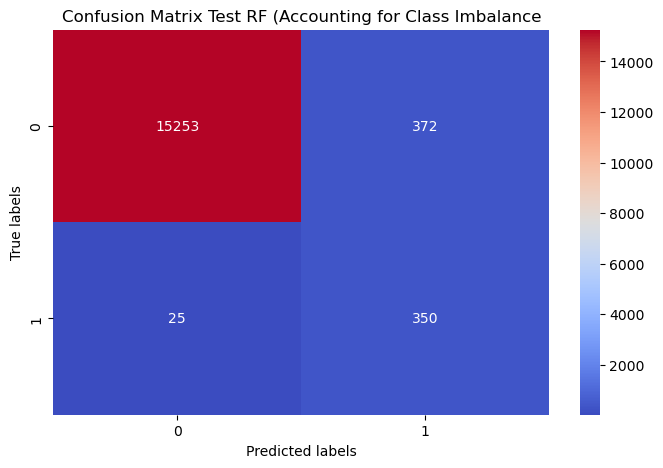

In [20]:
y_pred_test = classifier_rf.predict(test_df_x)

conf_matrix_test = confusion_matrix(test_df_y, y_pred_test)
misclassification_test = 1 - accuracy_score(test_df_y, y_pred_test)
print("The Test Missclassification Rate RF (Accounting for Class Imbalance) is", round(misclassification_test,5))

y_pred_proba_test = classifier_rf.predict_proba(test_df_x)[:, 1] 

fpr, tpr, thresholds = roc_curve(test_df_y, y_pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,4)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Test RF (Accounting for Class Imbalance')
plt.legend(loc="center right")

print("\nConfusion Matrix Test RF (Accounting for Class Imbalance):\n")
print(conf_matrix_test)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test RF (Accounting for Class Imbalance')
plt.show()

In [21]:
oob_error = 1 - classifier_rf.oob_score_
print("The Out of Bag Error estimate for the Random Forest Classifer While Accounting For Class Imbalance is", round(oob_error,5))

The Out of Bag Error estimate for the Random Forest Classifer While Accounting For Class Imbalance is 0.02665


In [22]:
comparison_oob_test = pd.DataFrame([{"Test Error":misclassification_test,"OOB Error":oob_error}])
comparison_oob_test

Test Error  OOB Error
0    0.024813    0.02665

The OOB Error and Test Error are roughly the same now suggesting that the dataset imbalance was accounted for.

# 1E: One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

### Training Set XGBoost with CV to Find Best Alpha

In [23]:
xgb_model = xgb.XGBClassifier(random_state=1, reg_lambda=0, objective='binary:logistic')  

parameters = {'xgbclassifier__reg_alpha': np.logspace(-5, 2,num=15)} 
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=parameters, scoring='accuracy', cv=5)
grid_search_xgb.fit(train_df_x, train_df_y)

best_alpha = grid_search_xgb.best_params_['xgbclassifier__reg_alpha']
print(f"Best Alpha from XG Boost: {best_alpha}")

y_pred_train = grid_search_xgb.predict(train_df_x)

best_accuracy_train = round(grid_search_xgb.best_score_, 5)
print('Best XGBoost CV Training Accuracy:', best_accuracy_train)
best_error_train = round((1-best_accuracy_train),5)
print('Best XGBoost CV Training Error:', best_error_train)

Best Alpha from XG Boost: 1e-05
Best XGBoost CV Training Accuracy: 0.9945
Best XGBoost CV Training Error: 0.0055


### Training Set XGBoost ROC, AUC, and Confusion Matrix

AUC Score: 1.0

Confusion Matrix XG Boost Train:

[[59000     0]
 [    1   999]]



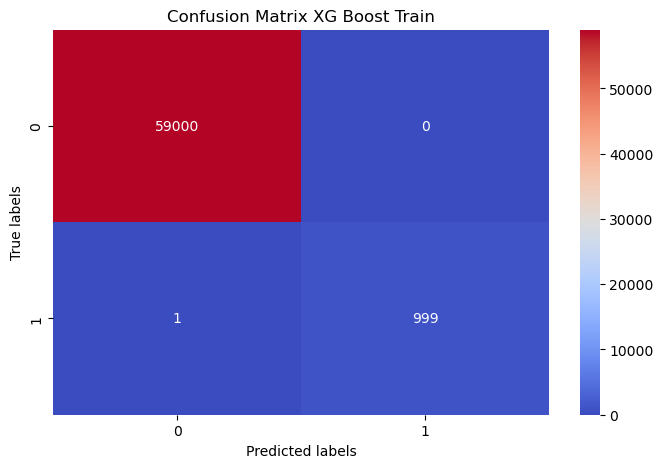

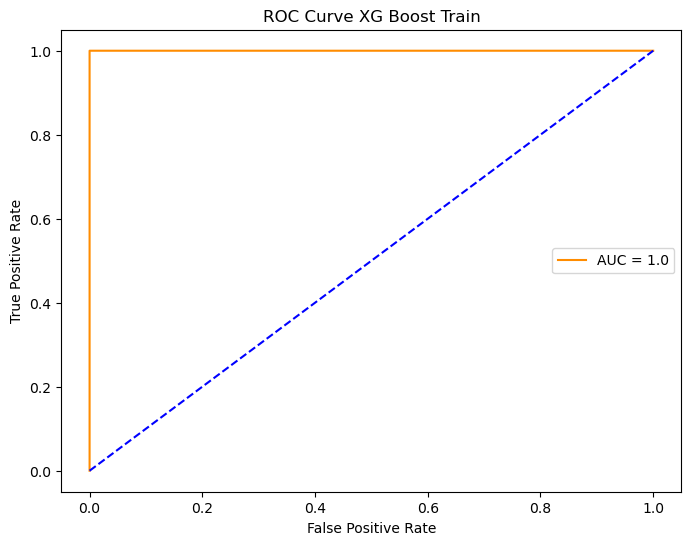

In [24]:
y_pred_train_proba = grid_search_xgb.predict_proba(train_df_x)[:, 1]  
roc_auc = roc_auc_score(train_df_y, y_pred_train_proba)

print(f"AUC Score: {roc_auc}\n")

conf_matrix_train = confusion_matrix(train_df_y, y_pred_train)
print("Confusion Matrix XG Boost Train:\n")
print(conf_matrix_train)
print()
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix XG Boost Train')
plt.show()

fpr, tpr, thresholds = roc_curve(train_df_y, y_pred_train_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,4)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XG Boost Train')
plt.legend(loc="center right")

### Testing Set XGBoost ROC, AUC, Confusion Matric

In [25]:
y_pred_test = grid_search_xgb.predict(test_df_x)
accuracy_test = accuracy_score(test_df_y, y_pred_test)
print("The Test Accuracy from the Best Alpha XG Boost:", accuracy_test)
error_test = round((1-accuracy_test),4)

print("The Test Error from the Best Alpha XG Boost:", error_test)

The Test Accuracy from the Best Alpha XG Boost: 0.9935
The Test Error from the Best Alpha XG Boost: 0.0065


AUC Score: 0.9939198293333333

Confusion Matrix for XG Boost Test Set:

[[15606    19]
 [   85   290]]


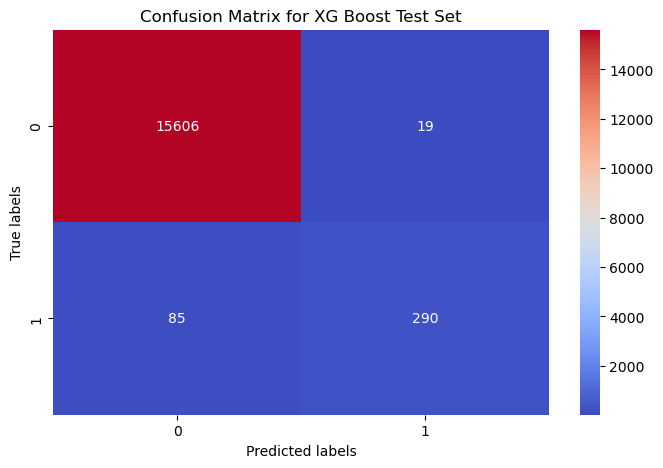

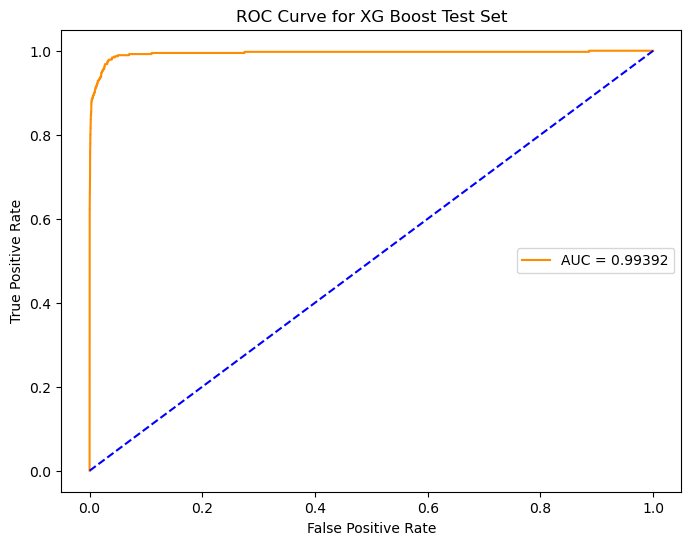

In [26]:
y_pred_test_proba = grid_search_xgb.predict_proba(test_df_x)[:, 1]  
roc_auc = roc_auc_score(test_df_y, y_pred_test_proba)

print(f"AUC Score: {roc_auc}\n")

conf_matrix_test = confusion_matrix(test_df_y, y_pred_test)
print("Confusion Matrix for XG Boost Test Set:\n")
print(conf_matrix_test)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XG Boost Test Set')
plt.show()

fpr, tpr, thresholds = roc_curve(test_df_y, y_pred_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,6)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XG Boost Test Set')
plt.legend(loc="center right")

In [27]:
comparison_xg = pd.DataFrame([{"Train Error":best_error_train,"Test Error":error_test}])
comparison_xg

Train Error  Test Error
0       0.0055      0.0065

The Train Error and Test Error on uncompensated XG Boost are both very low.

# 1F: Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBosst with L1-penalized lo- gistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

### Using SMOTE on Train Data to Tune Hyperparameters

Best alpha: 0.001
Best CV Training accuracy from XG Boost with SMOTE: 0.98884
Confusion Matrix XG Boost Train Set Using SMOTE:

[[59000     0]
 [    1   999]]


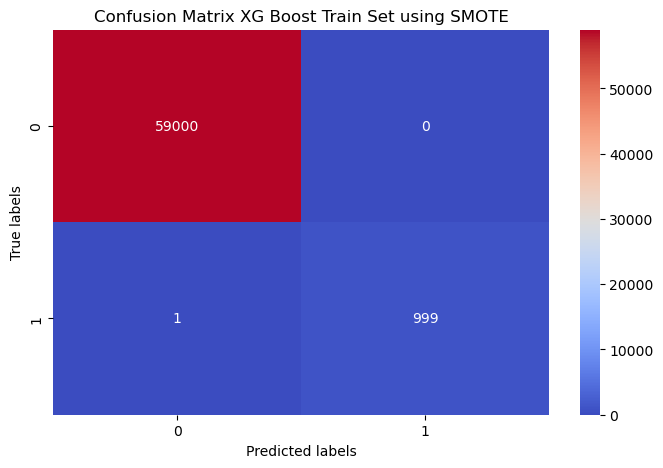

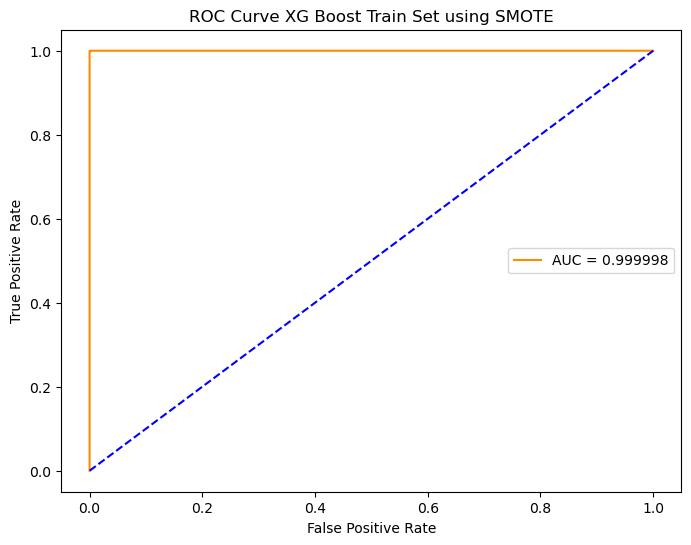

In [28]:
pipeline = make_pipeline(SMOTE(random_state=1),XGBClassifier(random_state=1, reg_lambda=0, objective='binary:logistic'))

parameters = {'xgbclassifier__reg_alpha': np.logspace(-5, 2,num=15)} 
grid_search_xgb = GridSearchCV(estimator=pipeline,param_grid=parameters,scoring='roc_auc',cv=5,n_jobs=-1).fit(train_df_x, train_df_y)

best_alpha = grid_search_xgb.best_params_['xgbclassifier__reg_alpha']
print(f"Best alpha: {best_alpha}")

y_pred_train = grid_search_xgb.predict(train_df_x)

best_accuracy_train = round(grid_search_xgb.best_score_, 5)
print('Best CV Training accuracy from XG Boost with SMOTE:', best_accuracy_train)


conf_matrix_train = confusion_matrix(train_df_y, y_pred_train)
print("Confusion Matrix XG Boost Train Set Using SMOTE:\n")
print(conf_matrix_train)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix XG Boost Train Set using SMOTE')
plt.show()

y_pred_train_proba = grid_search_xgb.predict_proba(train_df_x)[:, 1]  

fpr, tpr, thresholds = roc_curve(train_df_y, y_pred_train_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,6)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XG Boost Train Set using SMOTE')
plt.legend(loc="center right")

After setting up a pipeline such that SMOTE runs within every cross validation fold, the best alpha found was 0.001. The train data was then fit using this parameters and produced a train accuracy of 0.98887 and AUC of 0.999998 showing high separatibility.

### Test Set XG Boost trained using SMOTE

The Test Accuracy from the Best Alpha: 0.9931875
The Test Error from the Best Alpha: 0.0068

Confusion Matrix XG Boost Test (Trained from SMOTE):

[[15578    47]
 [   62   313]]


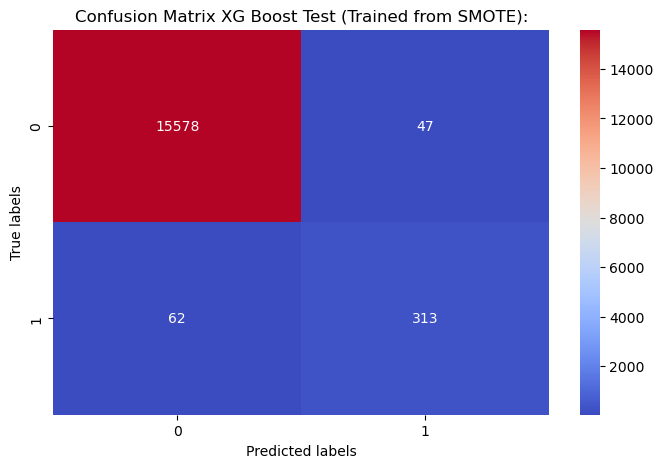

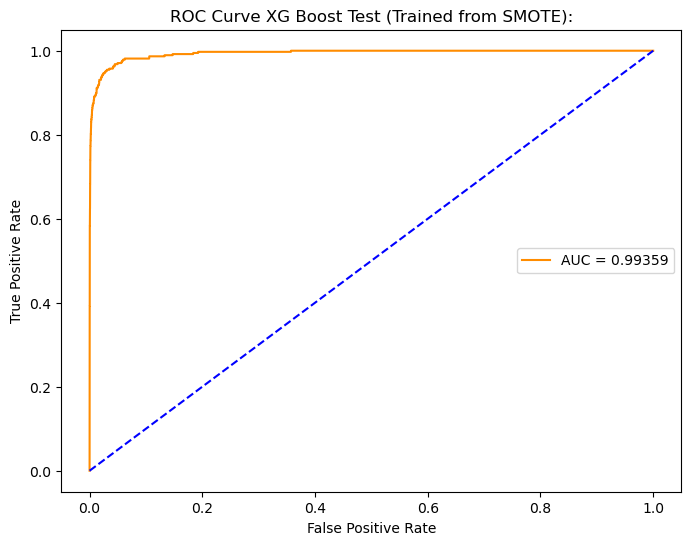

In [29]:
y_pred_test = grid_search_xgb.predict(test_df_x)
accuracy_test = accuracy_score(test_df_y, y_pred_test)
print("The Test Accuracy from the Best Alpha:", accuracy_test)
error_test_smote = round((1-accuracy_test),4)
print("The Test Error from the Best Alpha:", error_test_smote)

conf_matrix_test = confusion_matrix(test_df_y, y_pred_test)
print("\nConfusion Matrix XG Boost Test (Trained from SMOTE):\n")
print(conf_matrix_test)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix XG Boost Test (Trained from SMOTE):')
plt.show()

y_pred_test_proba = grid_search_xgb.predict_proba(test_df_x)[:, 1]  

fpr, tpr, thresholds = roc_curve(test_df_y, y_pred_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,6)}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XG Boost Test (Trained from SMOTE):')
plt.legend(loc="center right")

In [30]:
comparison_smote = pd.DataFrame([{"Test Error XG Boost W/O SMOTE":error_test,"Test Error XG Boost with SMOTE":error_test_smote}])
comparison_smote

Test Error XG Boost W/O SMOTE  Test Error XG Boost with SMOTE
0                         0.0065                          0.0068

After training using SMOTE and testing on the test set, a very slightly greater test error (+ 0.0003) was obtained. 

The confusion matrix however differs. The False Negative rate in the uncompensated model is slightly greater than the FN rate in the compensated model. As a trade off, the False Positive rate in the compensated model is higher than the compensated model. This may suggest that the SMOTE model did not overfit as much to the negative class as the FN rate has decreased and the FP rate increased when compared to the uncompensated model which had a high FN rate but a relatively lower FP rate. The SMOTE model as a result also had a greater True Positive rate when compared to that of the uncompensated model.

The AUC Between the uncompensated case and SMOTE case also did not change much at all (0.99392 for uncompensated vs 0.99359 for SMOTE).

# ISLR 6.6.3 
## Suppose we estimate the regression coefficients in a linear regression model by minimizing for a particular value of s. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

i. Increase initially, and then eventually start decreasing in an inverted U shape.

ii. Decrease initially, and then eventually start increasing in a U shape.

iii. Steadily increase. 

iv. Steadily decrease. 

v. Remain constant.

### (a) As we increase s from 0, the training RSS will:

The training RSS would steadily decrease. The train RSS will decrease until it reaches the least squares solution.

### (b) Repeat (a) for test RSS. 

The test RSS would decrease initially, and then eventually start increasing in a U shape. As the constraints on Beta are being eased, the Test RSS would decrease as we approach the best Beta however it would again start to increase after this point as it will start to overfit

### (c) Repeat (a) for variance.

The variance would steadily increase as the model becomes more flexible with an increase in s from 0.

### (d) Repeat (a) for (squared) bias.

The squared bias would steadily decrease because the model's flexibility increases. As variance increases, bias decreases (vice versa).

### (e) Repeat (a) for the irreducible error.

It would remain constant as it irreducible is error that cannot be reduced as it is unknown what is causing that error.

# ISLR 6.6.5

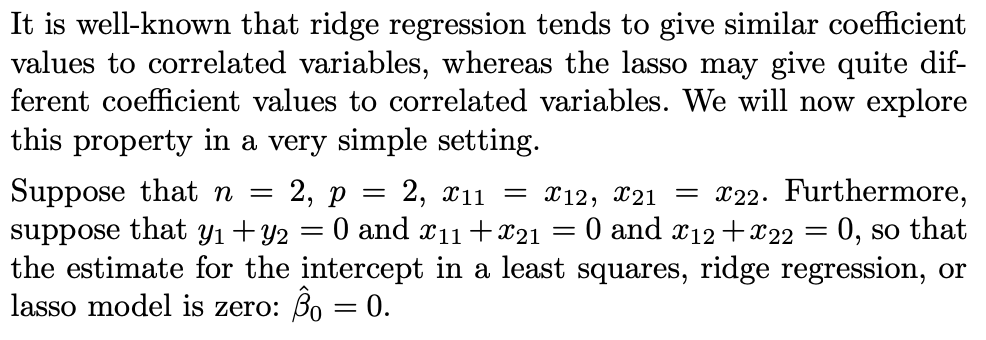

(a) Write out the ridge regression optimization problem in this setting.

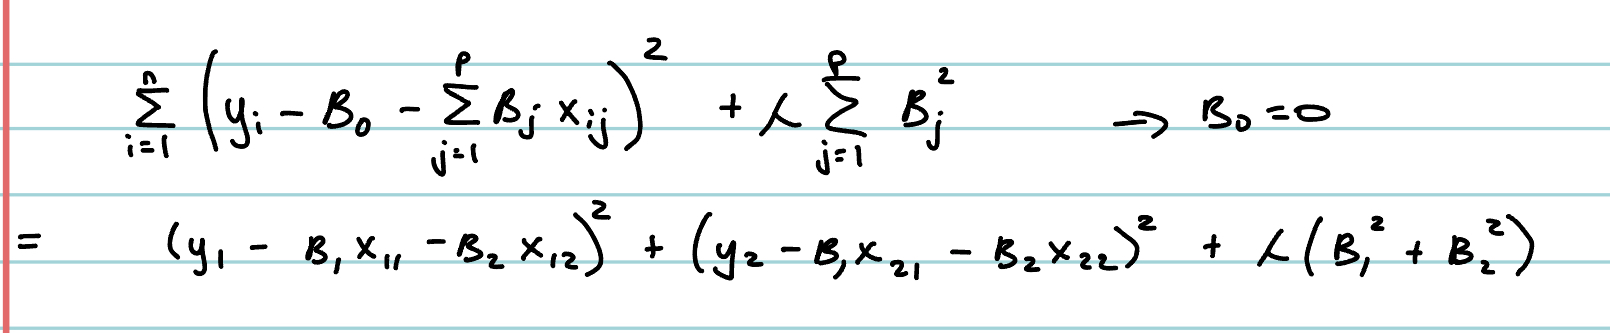

(b) Argue that in this setting, the ridge coefficient estimates satisfy βˆ 1 = βˆ 2 .

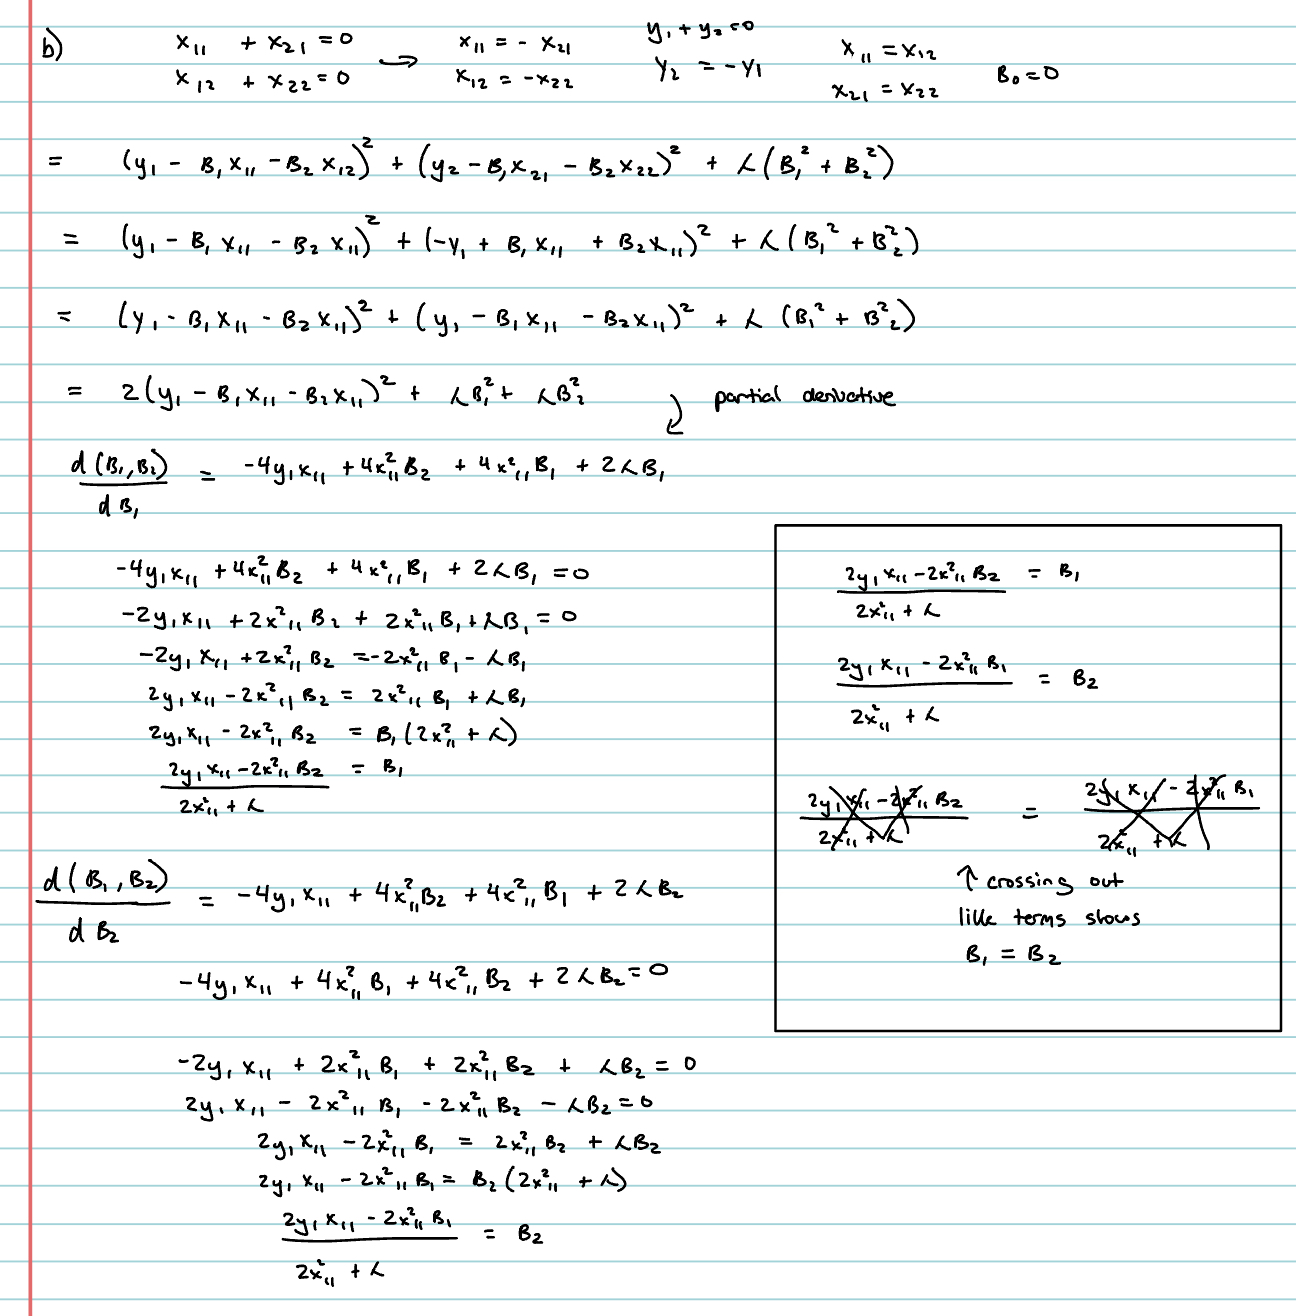

(c) Write out the lasso optimization problem in this setting.

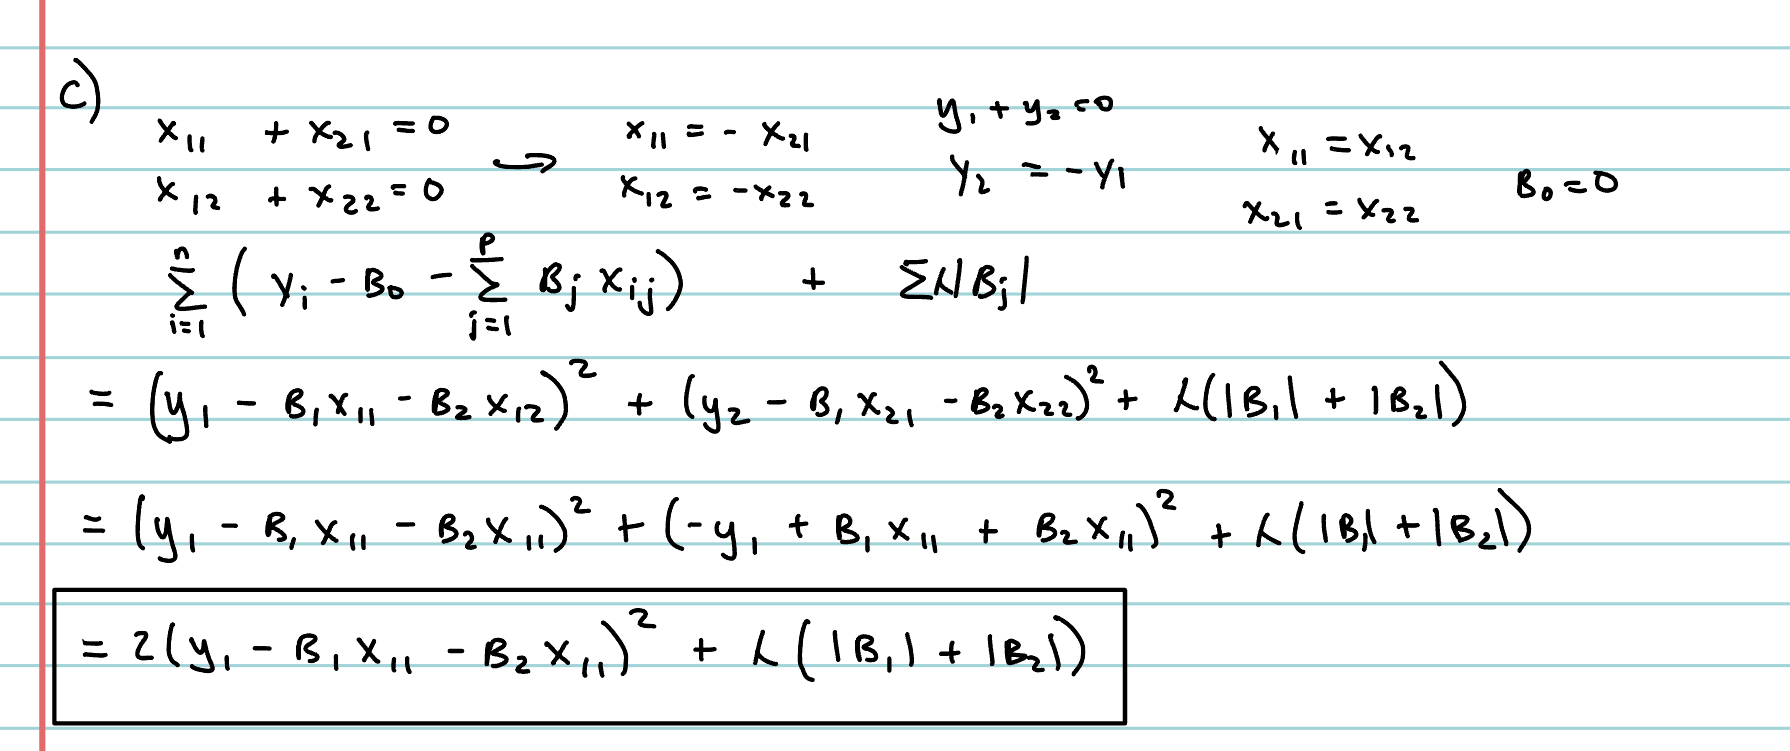

(d) Argue that in this setting, the lasso coefficients βˆ1 and βˆ2 are not unique—in other words, there are many possible solutions to the optimization problem in (c).

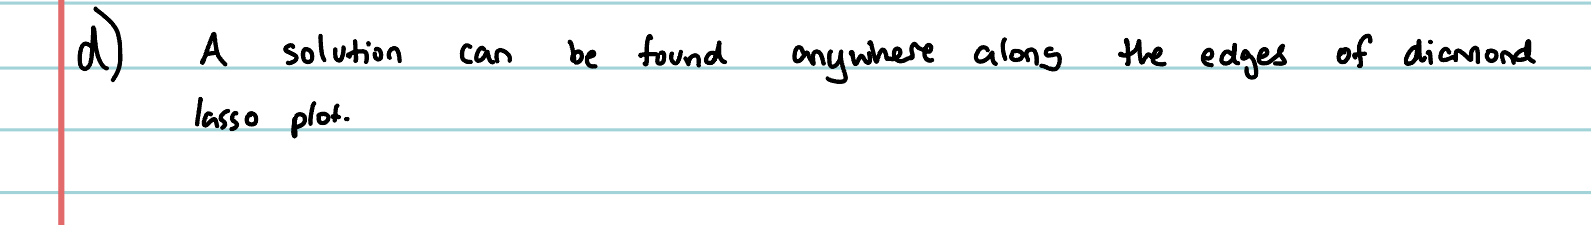

# ISLR 8.4.5

### Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X): 0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7, and0.75.


### There are two common ways to combine these results together into a single class prediction.


### One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?


Using majority vote the final classification would be red as 6 appeared to be greater than 0.5 probability and 4 were under 0.5.

When using average probability, we would average all the probabilities which is 4/5/10 = 0.45 so we would classify it to green.

# ISLR 9.7.3

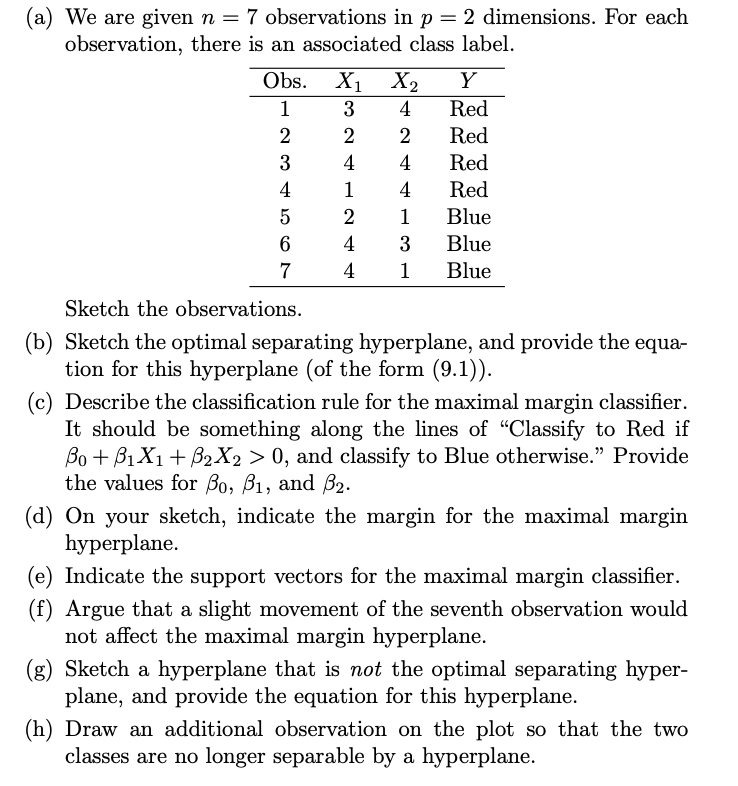

# A)

Text(0.5, 1.0, 'Observations')

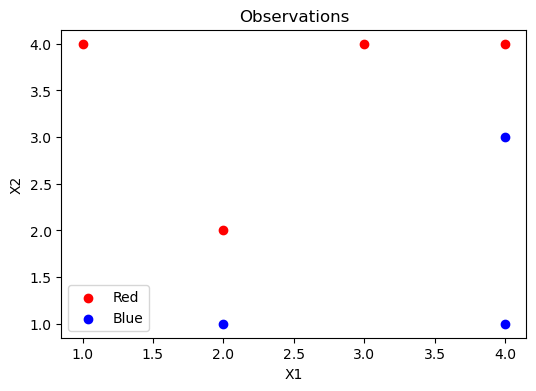

In [31]:
X = np.array([[3, 4], [2, 2], [4, 4], [1, 4], [2, 1], [4, 3], [4, 1]])
y = np.array([1, 1, 1, 1, 0, 0, 0]) 

plt.figure(figsize=(6, 4))
plt.scatter(X[:4, 0], X[:4, 1], color='red', label='Red')
plt.scatter(X[4:, 0], X[4:, 1], color='blue', label='Blue')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Observations')

# B) and D) and E)

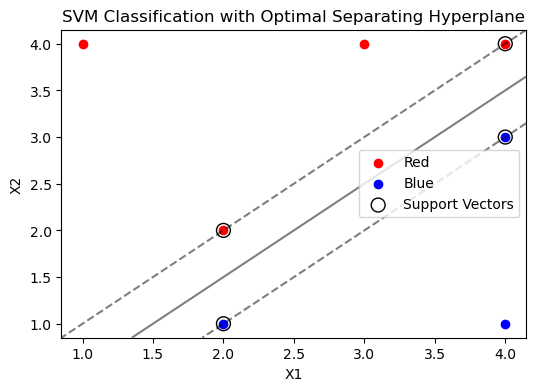

In [34]:
X = np.array([[3, 4], [2, 2], [4, 4], [1, 4], [2, 1], [4, 3], [4, 1]])
y = np.array([1, 1, 1, 1, 0, 0, 0]) 

model = svm.SVC(kernel='linear', C=1000)
model.fit(X, y)

plt.figure(figsize=(6, 4))
plt.scatter(X[:4, 0], X[:4, 1], color='red', label='Red')
plt.scatter(X[4:, 0], X[4:, 1], color='blue', label='Blue')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x = np.linspace(xlim[0], xlim[1], 30)
Y = np.linspace(ylim[0], ylim[1], 30)
Y_mesh, X_mesh = np.meshgrid(Y, x)
xy = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
Z = model.decision_function(xy).reshape(X_mesh.shape)

ax.contour(X_mesh, Y_mesh, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,linewidth=1, facecolors='none', edgecolors='k', label='Support Vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('SVM Classification with Optimal Separating Hyperplane')
plt.show()

# B) and C)

In [33]:
coeff = model.coef_[0]
coeff_1, coeff_2 = coeff[0], coeff[1]
b = model.intercept_[0]

print(f"The equation of the hyperplane is: {coeff_1}x_1 + {coeff_2}x_2 + {b} = 0 ")

print(f"\nThe classification rule for the maximal margin classifier is: {coeff_1}x_1 + {coeff_2}x_2 + {b} >= 0 is red otherwise it is blue")

The equation of the hyperplane is: -1.999414062500001x_1 + 1.9994140625x_2 + 0.9997070312500023 = 0 

The classification rule for the maximal margin classifier is: -1.999414062500001x_1 + 1.9994140625x_2 + 0.9997070312500023 >= 0 is red otherwise it is blue


# F)

The seventh data point (4,1) is located far away from the hyperplane so a slight movement would not really affect anything.

# G)

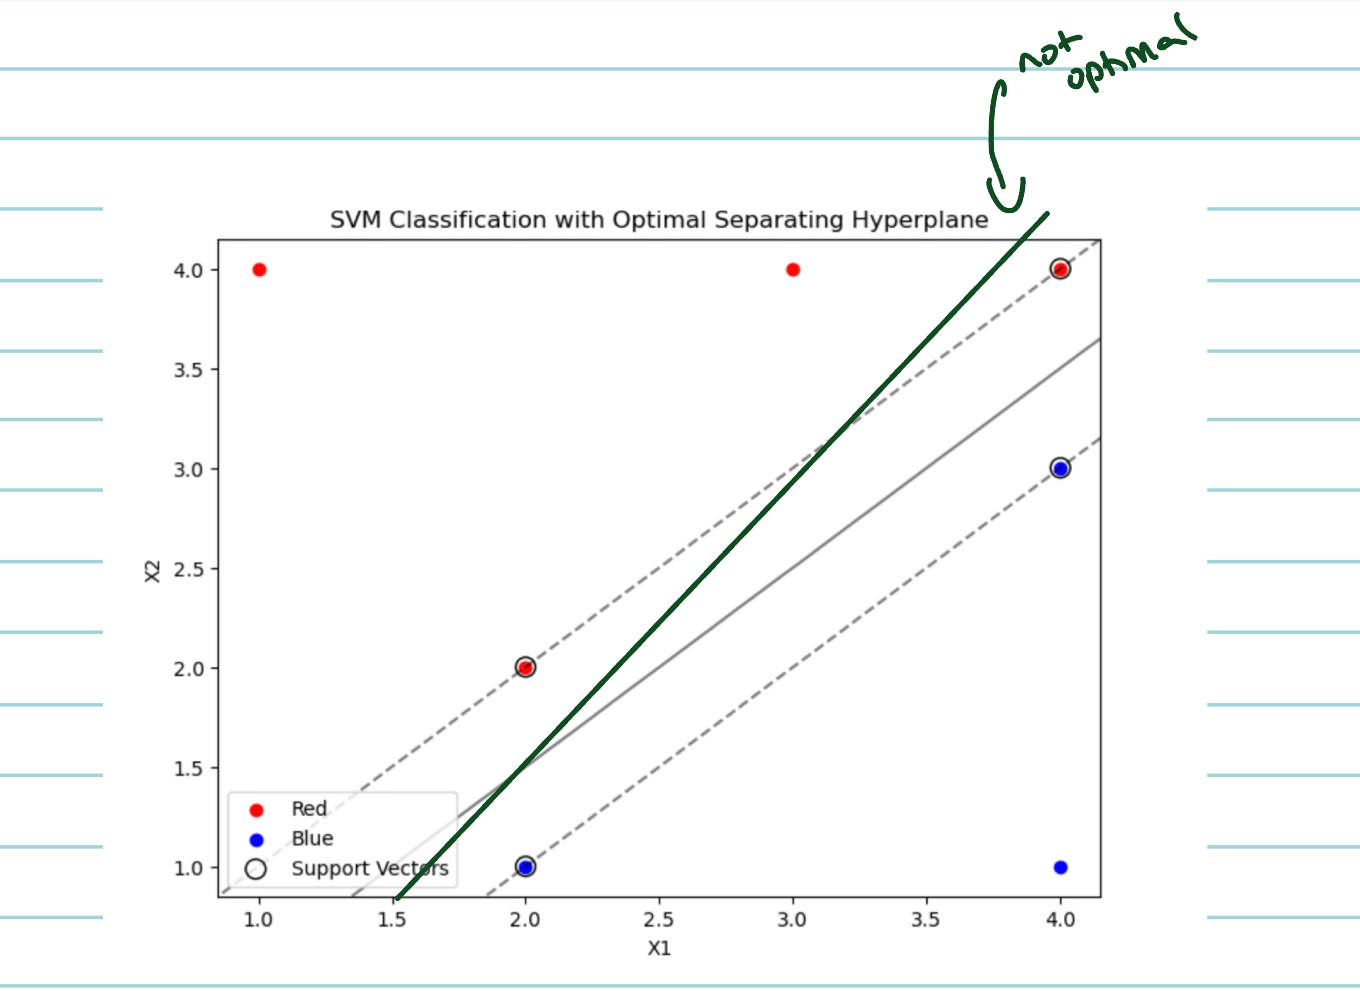

# H)

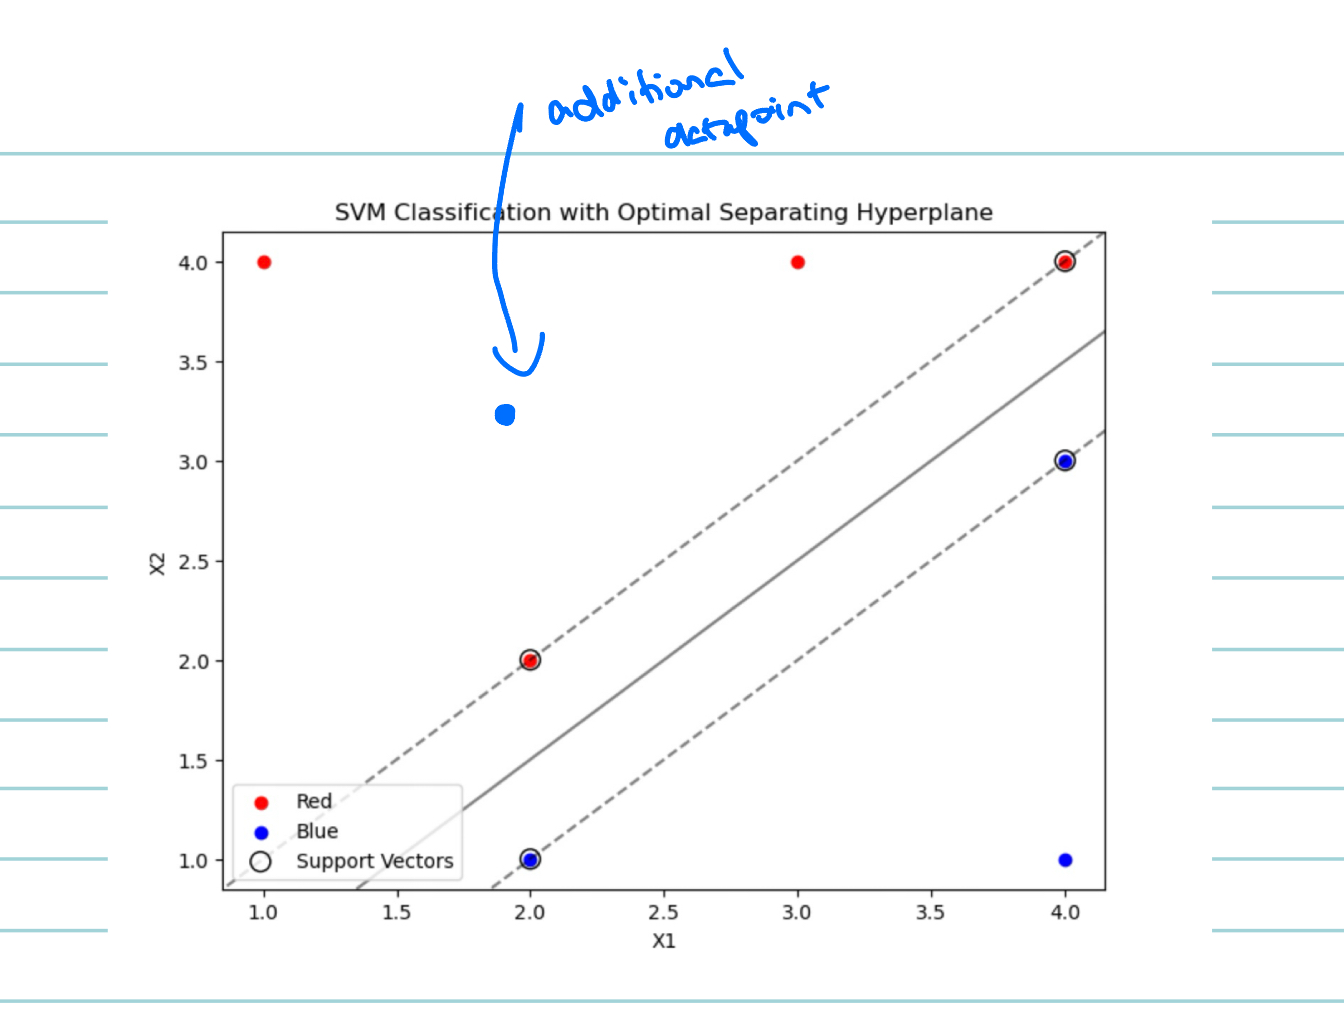

# References

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python